In [214]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from openpyxl import load_workbook
import seaborn as sns

In [215]:
red1 = '#891D2D'
red2 = '#BA3B31'
orange = '#F58221'
yellow = '#FCAF19'
brown = '#440A15'
brown2 = '#B45419'
purple1 = '#3B1053'
purple2 = '#76518E'
purple3 = '#B69DC7'
teal1 = '#032838'
teal2 = '#154655'
teal3 = '#527D77'
teal4 = '#8DB5AF'
teal1 = '#294839'
green1 = '#6DA08C'
green2 = '#6E966E'
green3 = '#A3BDA3'
beige1 = '#7A693B'
beige2 = '#A89677'
beige3 = '#D2CDAD'
grey1 = '#E7E7E7'
grey2 = '#D7D7D7'
grey3 = '#C6C6C6'
grey4 = '#939393'
blue1 = '#3EA1C0'

In [235]:
WACC = 0.05
discountrate = 0.04
NoOfPeakSeason = 2
lengthPeakSeason = 1
NoOfRegSeason = 4
lengthRegSeason = 2158
LeapYearsInvestment = 5
fix_sample = 'no' # fix_sample = True --> 'no', fix_sample = False = 'random'
season_scale = [(8760 - NoOfPeakSeason * lengthPeakSeason) / NoOfRegSeason / lengthRegSeason
                            for x in range(NoOfRegSeason)] + [1 for x in range(NoOfPeakSeason)]
new_names = ['CCGT',   'OCGT',  'Biomass',  'Oil'  ,'Wind', 'Solar', 'Hydro ror', 'Hydro storage', 'Geothermal']
new_names_2 = ['CCGT',   'OCGT',  'Biomass',  'Oil'  ,'Wind', 'Solar', 'Hydro', 'Geothermal']
old_names = ['Gas CCGT',    'Gas OCGT',  'Bio',   'Oil existing',  'Wind onshore',  'Solar'  ,'Hydro run-of-the-river', 'Hydro regulated', 'Geo']
scenario = '1'
date = '0527'
time = '0922_BASEVAL'
 
file_path = 'Results/bolivia_v1_reg' + str(lengthRegSeason) + '_peak' + str(lengthPeakSeason) + '_sce' + scenario + '_' + fix_sample + 'SGR_2024' + date + time + '/results_output_EuropePlot.csv'
operational_data = pd.read_csv('Results/bolivia_v1_reg' + str(lengthRegSeason) + '_peak' + str(lengthPeakSeason) + '_sce' + scenario + '_' + fix_sample + 'SGR_2024' + date + time +'/results_output_Operational.csv')
investment_data = pd.read_csv('Results/bolivia_v1_reg' + str(lengthRegSeason) + '_peak' + str(lengthPeakSeason) + '_sce' + scenario + '_' + fix_sample + 'SGR_2024' + date + time +'/results_output_gen.csv')
objective_value = pd.read_csv('Results/bolivia_v1_reg' + str(lengthRegSeason) + '_peak' + str(lengthPeakSeason) + '_sce' + scenario + '_' + fix_sample + 'SGR_2024' + date + time +'/results_objective.csv', header=None)
transmission_data = pd.read_csv('Results/bolivia_v1_reg' + str(lengthRegSeason) + '_peak' + str(lengthPeakSeason) + '_sce' + scenario + '_' + fix_sample + 'SGR_2024' + date + time +'/results_output_transmision.csv')
stor_data = pd.read_csv('Results/bolivia_v1_reg' + str(lengthRegSeason) + '_peak' + str(lengthPeakSeason) + '_sce' + scenario + '_' + fix_sample + 'SGR_2024' + date + time +'/results_output_stor.csv')
node_sheet = load_workbook('Data handler/bolivia_v1/Node.xlsx')
 
scenario_int = int(scenario)
prob_scenarios = {f"scenario{i}": 1/scenario_int for i in range(1,scenario_int+1)}
regular_seasons = ['winter', 'spring', 'summer', 'fall']
peak_seasons = ['peak1', 'peak2']
start_year = 2025


cost_method = 'old'
new_run = True

In [236]:

# Helper functions
def get_colors(carriers):
    colors = [beige2, beige3, teal3, beige1, teal4, yellow, teal2, brown2]
    color_dict = dict(zip(new_names_2, colors))
    colors_new = [color_dict[carrier] for carrier in carriers]
    return colors_new

def rename_columns(df):
    old_names_no_space = [names.replace(" ", "") for names in old_names]
    name_map= dict(zip(old_names_no_space, new_names))
    df = df.rename(columns=name_map)
    return df

def open_csv(file, included_rows):
    data_list = []
    with open(file, 'r') as f:
        next(f)
        headers = f.readline().strip().split(',')  # Read the first line to get headers
        for i, line in enumerate(f, start=2):  # Start counting from 2 since headers are at line 1
            if i in included_rows:
                # Split the line by comma, or change delimiter as necessary
                values = line.strip().split(',')
                # Create a dictionary for the row using a dictionary comprehension and zip to pair headers and values
                row_data = dict(zip(headers, values))
                data_list.append(row_data)
    return pd.DataFrame(data_list)

def rename_columns_operations(df):
    operations_names = ['GasCCGT_MW', 'GasOCGT_MW', 'Bio_MW', 'Oilexisting_MW', 'Windonshore_MW', 'Solar_MW', 'Hydrorun-of-the-river_MW', 'Hydroregulated_MW', 'Geo_MW']
    name_map= dict(zip(operations_names, new_names))
    df = df.rename(columns=name_map)
    return df

def custom_autopct(pct):
    return ('%1.1f%%' % pct) if pct > 0 else ''

def get_marginal_cost(technology, period):
    generator_file = load_workbook('Data handler/bolivia_v1/Generator.xlsx')
    generator_efficiency = generator_file['Efficiency']
    generator_VOM = generator_file['VariableOMCosts']
    generator_fuel_cost = generator_file['FuelCosts']
 
    for row in range(2, generator_efficiency.max_row + 1):  
        if generator_efficiency.cell(row, 1).value == technology and generator_efficiency.cell(row, 2).value == period:
            efficiency = generator_efficiency.cell(row, 3).value  
            break  
 
    for row in range(2, generator_VOM.max_row + 1):
        if generator_VOM.cell(row, 1).value == technology:
            VOM = generator_VOM.cell(row, 2).value
            break
 
    for row in range(2, generator_fuel_cost.max_row + 1):
        if generator_fuel_cost.cell(row, 1).value == technology and generator_fuel_cost.cell(row, 2).value == period:
            fuel_cost = generator_fuel_cost.cell(row, 3).value
            break
 
    marginal_cost = (3.6 / efficiency) * fuel_cost + VOM
    return marginal_cost

def calculate_present_value(future_value, year, base_year, discount_rate=discountrate):
    return future_value / ((1 + discount_rate) ** (year - base_year))

def empire_factor(period,lifetime):
    return (1-(1+discountrate)**-min((3-period+1)*5,lifetime))/(1-(1+discountrate)**-1)

def calculate_annuity_gen(carrier):
    generator_file = load_workbook('Data handler/bolivia_v1/Generator.xlsx')
    generator_capcost = generator_file['CapitalCosts']
    for row in range(4, generator_capcost.max_row + 1):  
        if generator_capcost.cell(row, 1).value == carrier:
            capitalCost = generator_capcost.cell(row, 3).value  
            break
    generator_FOM = generator_file['FixedOMCosts']
    for row in range(4, generator_FOM.max_row + 1):  
        if generator_FOM.cell(row, 1).value == carrier:
            FixedOMCost = generator_FOM.cell(row, 3).value  
            break
    generator_lifetime = generator_file['Lifetime']
    for row in range(4, generator_lifetime.max_row + 1):  
        if generator_lifetime.cell(row, 1).value == carrier:
            lifetime = generator_lifetime.cell(row, 2).value  
            break
    return ((WACC/(1-((1+WACC)**(-lifetime))))*capitalCost+FixedOMCost)*1000

def calculate_annuity_stor(tech):
    store_file = load_workbook('Data handler/bolivia_v1/Storage.xlsx')
    power_capcost = store_file['PowerCapitalCost']
    for row in range(4, power_capcost.max_row + 1):  
        if power_capcost.cell(row, 1).value == tech:
            powerCapitalCost = power_capcost.cell(row, 3).value  
            break
    energy_capcost = store_file['EnergyCapitalCost']
    for row in range(4, energy_capcost.max_row + 1):  
        if energy_capcost.cell(row, 1).value == tech:
            energyCapitalCost = energy_capcost.cell(row, 3).value  
            break
    power_FOM = store_file['PowerFixedOMCost']
    for row in range(4, power_FOM.max_row + 1):  
        if power_FOM.cell(row, 1).value == tech:
            powerFixedOMCost = power_FOM.cell(row, 3).value  
            break
    energy_FOM = store_file['EnergyFixedOMCost']
    for row in range(4, energy_FOM.max_row + 1):  
        if energy_FOM.cell(row, 1).value == tech:
            energyFixedOMCost = energy_FOM.cell(row, 3).value  
            break
    power_lifetime = store_file['Lifetime']
    for row in range(4, power_lifetime.max_row + 1):  
        if power_lifetime.cell(row, 1).value == tech:
            Lifetime = power_lifetime.cell(row,2).value  
            break
    return ((WACC/(1-((1+WACC)**(-Lifetime))))*powerCapitalCost+powerFixedOMCost)*1000, ((WACC/(1-((1+WACC)**(-Lifetime))))*energyCapitalCost+energyFixedOMCost)*1000

def calculate_annuity_transmision(node1, node2):
    transmision_file = load_workbook('Data handler/bolivia_v1/Transmission.xlsx')
    transmision_capcost = transmision_file['TypeCapitalCost']
    transmissionCapitalCost = transmision_capcost.cell(4,3).value
    transmission_FOM = transmision_file['TypeFixedOMCost']
    transmissionFixedOMCost = transmission_FOM.cell(4,3).value
    transmission_lifetime = transmision_file['Lifetime']
    transmissionLifetime = transmission_lifetime.cell(4,3).value
    transmission_length = transmision_file['Length']
    for row in range(1, transmission_length.max_row + 1):  
        if transmission_length.cell(row, 1).value.replace(' ','') == node1 and transmission_length.cell(row, 2).value.replace(' ','') == node2:
            length = transmission_length.cell(row, 3).value  
            break
    return (((WACC/(1-((1+WACC)**(-transmissionLifetime))))*transmissionCapitalCost*length)+transmissionFixedOMCost)

def calculate_present_value(future_value, year, base_year, discount_rate=discountrate):
    return future_value / ((1 + discount_rate) ** (year - base_year))
        

# Original decom dictionary

decom = {
    2025: {'BO0 1': ['OCGT', 16.84]},
    2026: {'BO0 5': ['OCGT', 49.76 + 51.37]},
    2027: {'BO0 1': ['OCGT', 15.99]},
    2028: {},
    2029: {'BO0 1': ['OCGT', 57.14 + 55.97]},
    2030: {'BO0 1': ['OCGT', 18.1], 'BO0 5': ['OCGT', 42.41 + 41.15]},
    2031: {'BO0 18': ['hydro', 2.55]},
    2032: {'BO0 10': ['oil', 1.1 + 1.12 + 1.12]},
    2033: {},
    2034: {},
    2035: {'BO0 10': ['oil', 1.1], 'BO0 28': ['oil', 1.1], 'BO0 2': ['solar', 5], 'BO0 11': ['onwind', 14.4], 'BO0 1': ['onwind', 39.6], 'BO0 19': ['onwind', 50.4]},
    2036: {'BO0 25': ['ror', 11.49], 'BO0 18': ['hydro', 6.23]},
    2037: {'BO0 27': ['ror', 6.81], 'BO0 1': ['OCGT', 57], 'BO0 6': ['OCGT', 1.49 + 1.49 + 1.6]},
    2038: {'BO0 1': ['OCGT', 18.79], 'BO0 6': ['OCGT', 1.55 + 1.51 + 1.6]},
    2039: {'BO0 11': ['biomass', 21], 'BO0 18': ['hydro', 6.2]},
    
}

# Function to determine the period for a given year
def get_period(year):
    return (year - start_year) // LeapYearsInvestment

# Initialize the result dictionary
periodic_decom = {}

# Aggregate decommissioning data into periods
for year, projects in decom.items():
    period = get_period(year) + 1
    if period not in periodic_decom:
        periodic_decom[period] = {}
    for site, data in projects.items():
        technology = data[0]
        capacity = data[1]
        if (site, technology) not in periodic_decom[period]:
            periodic_decom[period][(site, technology)] = 0
        periodic_decom[period][(site, technology)] += capacity
        
# Sum the decommissioned capacity for each technology in each period
total_decom = {}
for period, projects in periodic_decom.items():
    for (site, technology), capacity in projects.items():
        if technology not in total_decom:
            total_decom[technology] = {}
        if period not in total_decom[technology]:
            total_decom[technology][period] = 0
        total_decom[technology][period] += capacity
        
total_decom


{'OCGT': {1: 247.07, 2: 101.66, 3: 85.02999999999999},
 'hydro': {2: 2.55, 3: 12.43},
 'oil': {2: 3.3400000000000003, 3: 2.2},
 'solar': {3: 5},
 'onwind': {3: 104.4},
 'ror': {3: 18.3},
 'biomass': {3: 21}}

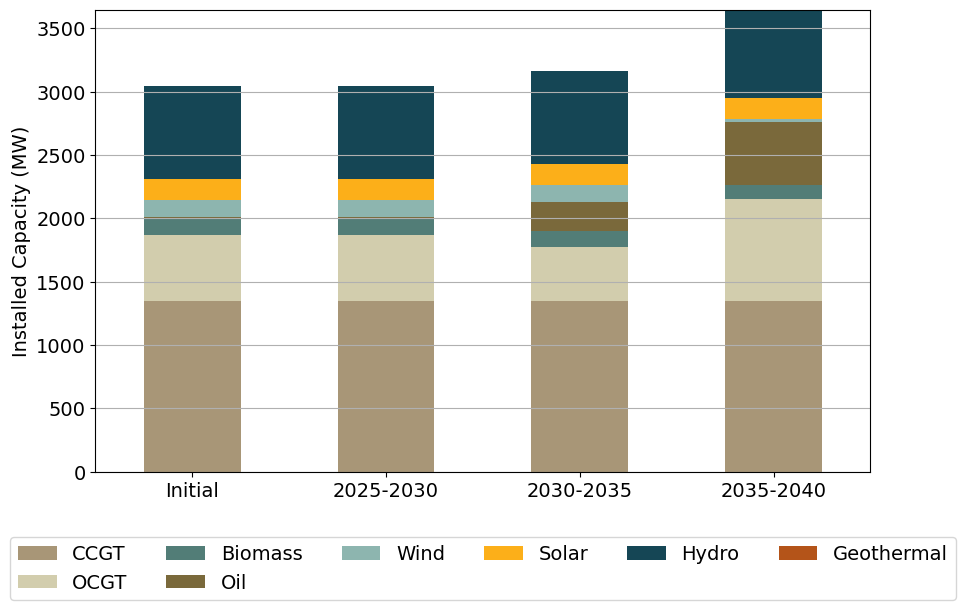

,CCGT,OCGT,Biomass,Oil,Wind,Solar,Hydro,Geothermal
,,,,,,,,
Initial,"1,343.07",527.61,127.72,12.00,131.40,165.08,734.85,0.00
2025-2030,"1,343.07",527.61,127.72,12.00,131.40,165.08,734.85,0.00
2030-2035,"1,343.07",425.95,127.72,233.39,131.40,165.08,732.30,0.00
2035-2040,"1,343.07",808.83,106.72,500.15,27.00,160.08,701.57,0.00


In [237]:
included_rows = [2,3,4,5]
installed_cap = open_csv(file_path, included_rows)
installed_cap.set_index('', inplace=True)

for column in installed_cap.columns:
    installed_cap[column] = pd.to_numeric(installed_cap[column], errors='coerce')

installed_cap = rename_columns(installed_cap)
installed_cap['Hydro'] = installed_cap['Hydro ror'] + installed_cap['Hydro storage']
installed_cap.drop(columns=['Hydro ror', 'Hydro storage'], inplace=True)
installed_cap = installed_cap[['CCGT', 'OCGT', 'Biomass', 'Oil', 'Wind', 'Solar', 'Hydro', 'Geothermal']]
installed_cap.plot(kind='bar', stacked=True, figsize=(10, 6), color=get_colors(installed_cap.columns))

# Adding titles and labels
plt.ylabel('Installed Capacity (MW)', fontsize=14)
plt.xticks(rotation = 0, fontsize=14)
plt.yticks(fontsize=14)
plt.grid(axis='y')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.12), ncol=6, fontsize=14)
plt.savefig('figures/InstalledCapacity.png', bbox_inches='tight')
plt.show()
installed_cap

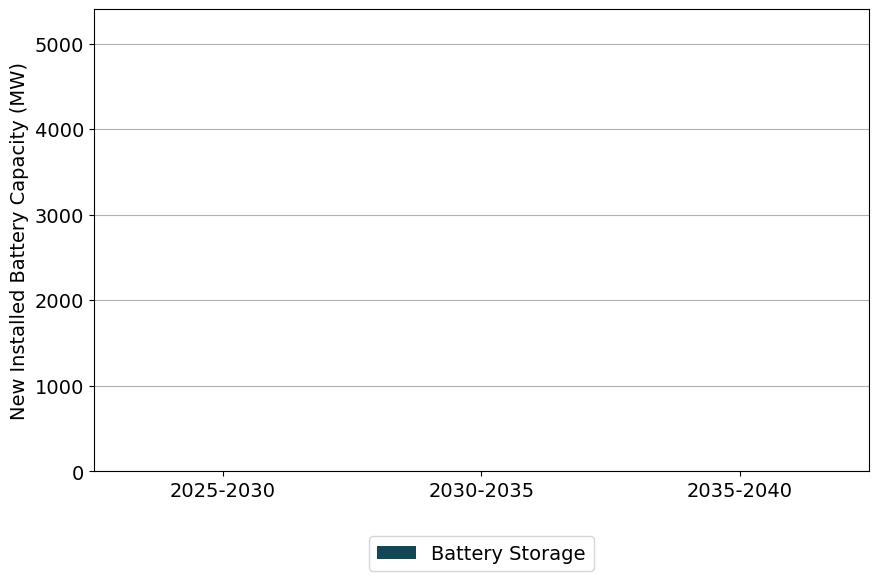

In [238]:
included_rows = [21, 22, 23]
installed_battery = open_csv(file_path, included_rows)
installed_battery.set_index('', inplace=True)

for column in installed_battery.columns:
    installed_battery[column] = pd.to_numeric(installed_battery[column], errors='coerce')

installed_battery.plot(kind='bar', stacked=True, figsize=(10, 6), color=teal2)

# Adding titles and labels
plt.ylabel('New Installed Battery Capacity (MW)', fontsize=14)
plt.xticks(rotation = 0, fontsize=14)
plt.yticks(fontsize=14)
plt.grid(axis='y')
plt.ylim(0, 5400)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.12), ncol=6, fontsize=14, labels=['Battery Storage'])
plt.savefig('figures/InstalledCapacity.png', bbox_inches='tight')
plt.show()

               0
2025-2030   0.00
2030-2035 276.51
2035-2040 488.04
764.5472264023006


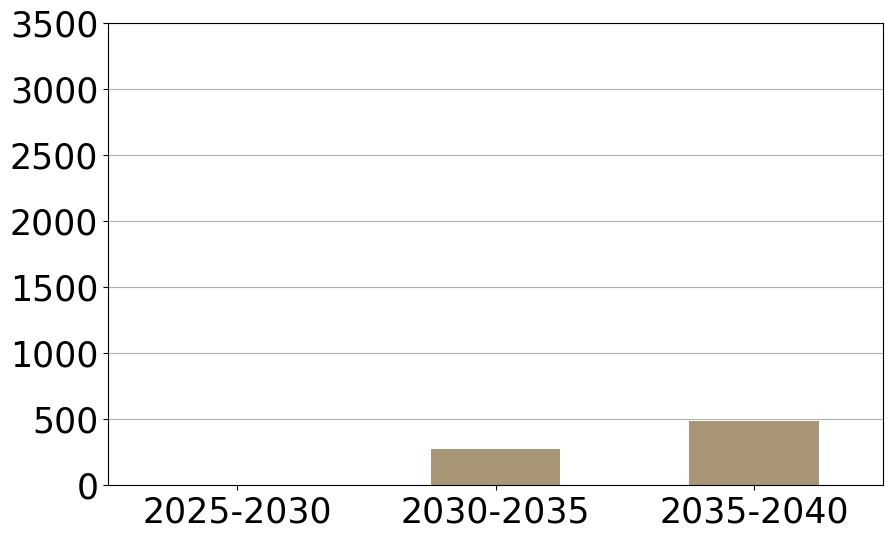

In [239]:
periods = ['2025-2030', '2030-2035', '2035-2040']
new_transmission_investments = []

for period in periods:
    new_transmission_investments.append(transmission_data[(transmission_data['Period'] == period)]['transmisionInvCap_MW'].sum())
new_transmission_investments = pd.DataFrame(new_transmission_investments)
new_transmission_investments.index = periods
new_transmission_investments.plot(kind='bar', stacked=True, figsize=(10, 6), color=beige2,legend=False)
print(new_transmission_investments)
print(new_transmission_investments.sum().sum())

#plt.ylabel('New installed Transmissionlines (MW)', fontsize=14)
plt.xticks(rotation = 0, fontsize=25)
plt.yticks(fontsize=25)
plt.grid(axis='y')
plt.ylim(0, 3500)
plt.savefig('figures/NewInstalledCapacity.png', bbox_inches='tight')
plt.show()

           CCGT    OCGT  Biomass    Oil    Wind  Solar  Hydro  Geothermal
                                                                         
2025-2030  0.00    0.00     0.00   0.00    0.00   0.00   0.00        0.00
2030-2035  0.00 -101.66     0.00 221.39    0.00   0.00  -2.55        0.00
2035-2040  0.00  382.88   -21.00 266.75 -104.40  -5.00 -30.73        0.00


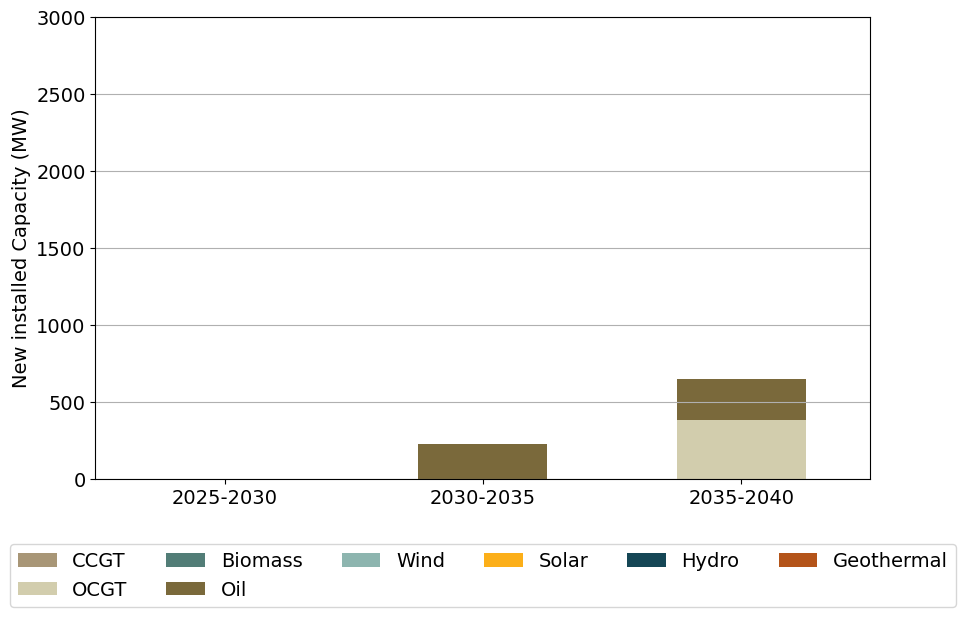

In [240]:
# New installed capacity
new_installed_cap = installed_cap.diff()
new_installed_cap = rename_columns(new_installed_cap)
# new_installed_cap['Hydro'] = new_installed_cap['Hydro ror'] + new_installed_cap['Hydro storage']
# new_installed_cap.drop(columns=['Hydro ror', 'Hydro storage'], inplace=True)
new_installed_cap = new_installed_cap.dropna()
new_installed_cap.plot(kind='bar', stacked=True, figsize=(10, 6), color=get_colors(installed_cap.columns))
print(new_installed_cap)

plt.ylabel('New installed Capacity (MW)', fontsize=14)
plt.xticks(rotation = 0, fontsize=14)
plt.yticks(fontsize=14)
plt.grid(axis='y')
plt.ylim(0, 3000)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.12), ncol=6, fontsize=14)
plt.savefig('figures/NewInstalledCapacity.png', bbox_inches='tight')
plt.show()

C:\Users\marih\AppData\Local\Temp\ipykernel_20224\3564526761.py:16: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  total_decom['Hydro'][3] += total_decom['ror'][3]
C:\Users\marih\AppData\Local\Temp\ipykernel_20224\3564526761.py:24: FutureWarn

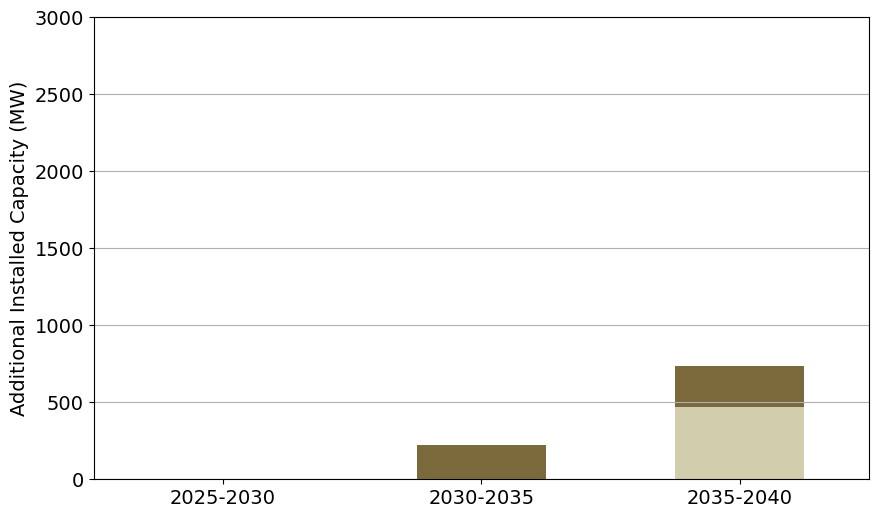

           CCGT   OCGT  Biomass  Hydro    Oil  Geothermal  Wind  Solar
                                                                      
2025-2030  0.00   0.00     0.00   0.00   0.00        0.00  0.00   0.00
2030-2035  0.00   0.00     0.00  -0.00 224.73        0.00  0.00   0.00
2035-2040  0.00 467.91     0.00   0.00 268.95        0.00  0.00   0.00
CCGT           0.00
OCGT         467.91
Biomass        0.00
Hydro          0.00
Oil          493.69
Geothermal     0.00
Wind           0.00
Solar          0.00
dtype: float64
961.5958282484378


In [241]:
# New installed capacity
new_installed_cap = installed_cap.diff()
new_installed_cap = rename_columns(new_installed_cap)
# new_installed_cap['Hydro'] = new_installed_cap['Hydro ror'] + new_installed_cap['Hydro storage']
# new_installed_cap.drop(columns=['Hydro ror', 'Hydro storage'], inplace=True)
new_installed_cap = new_installed_cap.dropna()
new_installed_cap = new_installed_cap[['CCGT', 'OCGT', 'Biomass', 'Hydro', 'Oil', 'Geothermal', 'Wind', 'Solar']]  
 
# total decom needs names with big first letter
total_decom = rename_columns(pd.DataFrame(total_decom))
# Change hydro column name to Hydro
total_decom = total_decom.rename(columns={'hydro': 'Hydro', 'onwind': 'Wind', 'biomass': 'Biomass', 'oil': 'Oil', 'OCGT': 'OCGT', 'solar': 'Solar'})
# Add the ror values in period 3 to the hydro column
# Drop ror column
if 'ror' in total_decom.columns:
    total_decom['Hydro'][3] += total_decom['ror'][3]
    total_decom.drop(columns='ror', inplace=True)
   
# Add the decommissioned capacity to the new installed capacity for period 2 and 3
for technology in new_installed_cap.columns:
    if technology in total_decom:
        # ignore if the technology has no decommissioned capacity, i.e. the value is NaN
        if pd.notna(total_decom[technology][2]):
            new_installed_cap[technology][1] += total_decom[technology][2]
        if pd.notna(total_decom[technology][3]):
            new_installed_cap[technology][2] += total_decom[technology][3]
        
 
 
new_installed_cap.plot(kind='bar', stacked=True, figsize=(10, 6), color=get_colors(new_installed_cap.columns), legend=False)
 
plt.ylabel('Additional Installed Capacity (MW)', fontsize=14)
plt.xticks(rotation = 0, fontsize=14)
plt.yticks(fontsize=14)
plt.grid(axis='y')
plt.ylim(0, 3000)
#plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.12), ncol=6, fontsize=14)
plt.savefig('figures/NewInstalledCapacity.png', bbox_inches='tight')
plt.show()

print(new_installed_cap)
print(new_installed_cap.sum())
print(new_installed_cap.sum().sum())

CCGT         30.87
OCGT          3.83
Oil           0.01
Geothermal    0.00
Hydro        10.87
Wind          0.43
Solar         0.86
Biomass       2.27
dtype: float64

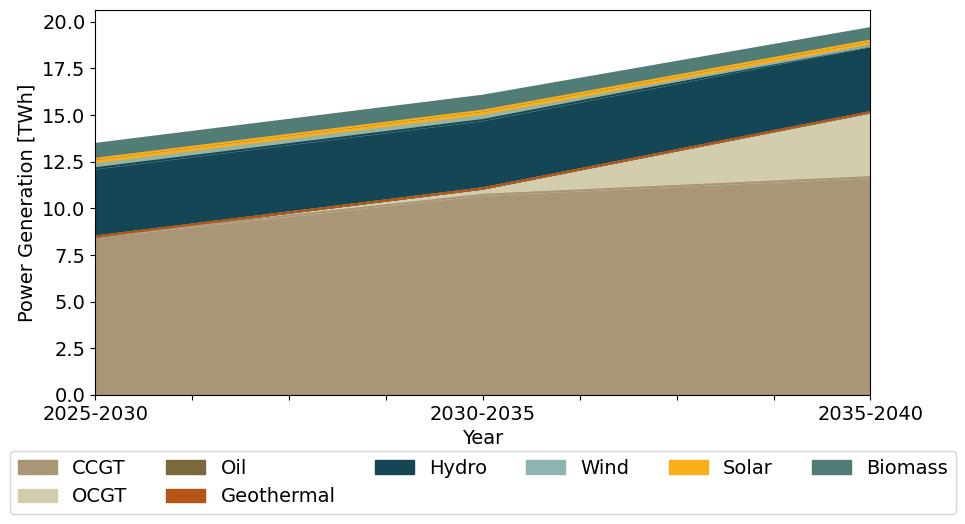

In [242]:
included_rows = [9,10,11]
pd.options.display.float_format = '{:,.2f}'.format

dispatch = open_csv(file_path, included_rows)
dispatch.set_index('', inplace=True)
for column in dispatch.columns:
    dispatch[column] = pd.to_numeric(dispatch[column], errors='coerce')

dispatch = rename_columns(dispatch)
dispatch /= 1000
dispatch['Hydro'] = dispatch['Hydro ror'] + dispatch['Hydro storage']
dispatch.drop(columns=['Hydro ror', 'Hydro storage'], inplace=True)

# reorder columns to ['CCGT',   'OCGT',  'Oil',  'Geothermal' , 'Hydro', 'Wind', 'Solar',   'Biomass']
dispatch = dispatch[['CCGT', 'OCGT', 'Oil', 'Geothermal', 'Hydro', 'Wind', 'Solar', 'Biomass']]
production_plot = dispatch.plot.area(stacked=True, color=get_colors(dispatch.columns),figsize=(10, 5))
production_plot.set_xlim(0,2)
plt.ylabel('Power Generation [TWh]', fontsize=14)
plt.xlabel('Year', fontsize=14)
plt.xticks(rotation = 0, fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.12), ncol=6, fontsize=14)
plt.savefig('figures/Production.png', bbox_inches='tight')

dispatch.sum()

In [243]:
period = '2035-2040'
scenario_number = 'scenario1'

filtered_data = operational_data[(operational_data['Period'] == period) & (operational_data['Scenario'] == scenario_number)]
old_names_no_space = [names.replace(" ", "") for names in old_names]
snapshot_columns = [tech + '_MW' for tech in old_names_no_space]
snapshot_columns.append('storDischarge_MW')
snapshot_columns.append('storCharge_MW')
snapshot_columns.append('Hour')
snapshot_columns.append('Load_MW')
snapshot_columns.append('LoadShed_MW')
snapshots = filtered_data[snapshot_columns]
snapshots.loc[:,'Hydrorun-of-the-river_MW'] = snapshots['Hydrorun-of-the-river_MW'] + snapshots['Hydroregulated_MW']
snapshots.drop(columns=['Hydroregulated_MW'], inplace=True)

# Sum based on Hour and then plot aggregated snapshots
snapshots = snapshots.groupby('Hour').sum()
fig, ax=plt.subplots(figsize = (11,6))
columns_to_plot = [col for col in snapshots.columns if col not in ['Hour', 'storCharge_MW', 'Load_MW']]
colors= [beige2, beige3, teal3, beige1, teal4, yellow, teal2, brown2, grey4, red1]
dispatch_plot = plt.stackplot(snapshots.index, [snapshots[col] for col in columns_to_plot], colors=colors, zorder=2)
plt.stackplot(snapshots.index, snapshots['storCharge_MW'] + snapshots['Load_MW'], labels=['storCharge_MW'], colors=[grey3], zorder=2)
plt.stackplot(snapshots.index, snapshots['Load_MW'], labels=['Load'], colors=[grey1], zorder=2)
plt.xticks(rotation = 0, fontsize=14)
plt.yticks(fontsize=14)
# scale_y = 1e3
# ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_y))
# ax.yaxis.set_major_formatter(ticks_y)
# myFmt = mdates.DateFormatter('%d %b')
# ax.xaxis.set_major_formatter(myFmt)
all_labels = new_names_2 + ['Battery discharge'] +['Load shedding'] + ['Battery charge'] + ['Load']
plt.legend(labels=all_labels,loc='upper center', bbox_to_anchor=(0.5, -0.06), ncol=6, fontsize=14)
ax.set_ylabel('Generation [GW]', fontsize=14)
ax.set_xlim(673, 697+23)
plt.savefig('figures/Dispatch.png', bbox_inches='tight')

KeyError: "['Oilexisting_MW'] not in index"

CCGT         63.16
OCGT          0.07
Oil           0.00
Geothermal    0.00
Hydro        27.06
Wind          1.63
Solar         2.12
Biomass       5.97
dtype: float64
CCGT         30.42
OCGT          0.05
Oil           0.00
Geothermal   27.70
Hydro        31.08
Wind          1.26
Solar         4.49
Biomass       5.00
dtype: float64
CCGT          6.92
OCGT          0.01
Oil           0.00
Geothermal   22.59
Hydro        24.64
Wind          0.10
Solar        18.91
Biomass      26.81
dtype: float64


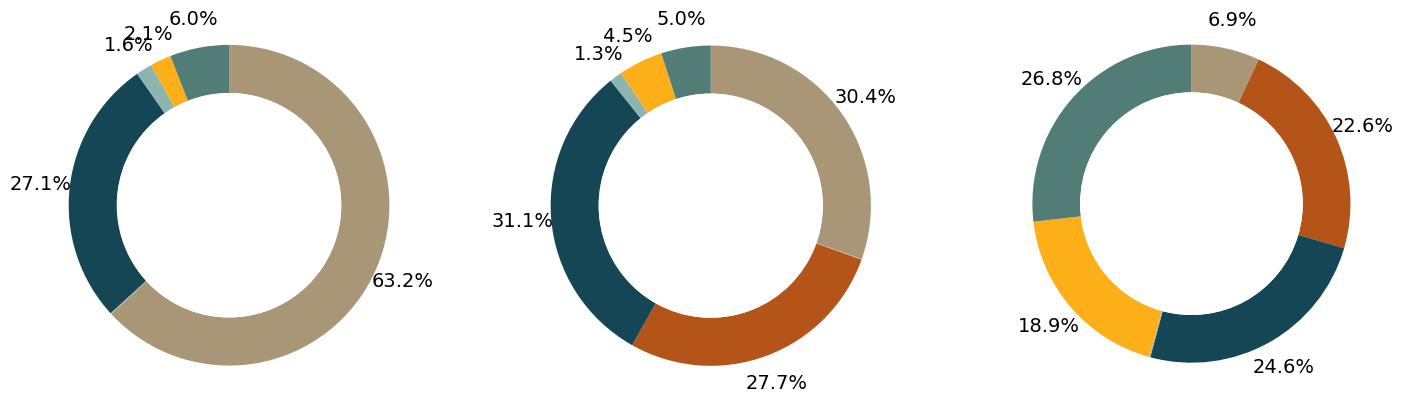

In [ ]:

dispatch_firstperiod = dispatch[:1][['CCGT', 'OCGT', 'Oil', 'Geothermal', 'Hydro', 'Wind', 'Solar', 'Biomass']]
dispatch_middleperiod = dispatch[1:2][['CCGT', 'OCGT', 'Oil', 'Geothermal', 'Hydro', 'Wind', 'Solar', 'Biomass']]
dispatch_lastperiod = dispatch[-1:][['CCGT', 'OCGT', 'Oil', 'Geothermal', 'Hydro', 'Wind', 'Solar', 'Biomass']]
 
plt.rcParams['font.size'] = 14
fig, (ax1, ax15, ax2) = plt.subplots(1, 3, figsize=(15, 5))
 
wedges1, texts1, autotexts1 = ax1.pie(
    dispatch_firstperiod.iloc[0].values, autopct=custom_autopct,
    colors=get_colors(dispatch_firstperiod.columns), startangle=90, counterclock=False,
    wedgeprops=dict(width=0.3), pctdistance=1.18
)

wedges15, texts15, autotexts15 = ax15.pie(
    dispatch_middleperiod.iloc[0].values, autopct=custom_autopct,
    colors=get_colors(dispatch_middleperiod.columns), startangle=90, counterclock=False,
    wedgeprops=dict(width=0.3), pctdistance=1.18
    
)
 
wedges2, texts2, autotexts2 = ax2.pie(
    dispatch_lastperiod.iloc[0].values, autopct=custom_autopct,
    colors=get_colors(dispatch_lastperiod.columns), startangle=90, counterclock=False,
    wedgeprops=dict(width=0.3), pctdistance=1.18
    
)
 
for autotext in autotexts1 + autotexts15 + autotexts2:
    if autotext.get_text() <= '0.3%':
        autotext.set_visible(False)
 
centre_circle1 = plt.Circle((0,0),0.70,fc='white')
ax1.add_artist(centre_circle1)
#ax1.set_title("2025 - 2030" +' Power Mix')

centre_circle15 = plt.Circle((0,0),0.70,fc='white')
ax15.add_artist(centre_circle15)
#ax15.set_title("2030 - 2035" +' Power Mix')
 
centre_circle2 = plt.Circle((0,0),0.70,fc='white')
ax2.add_artist(centre_circle2)
#ax2.set_title("2035 - 2040" +' Power Mix')
 
ax1.axis('equal')
ax15.axis('equal')
ax2.axis('equal')
 
#fig.legend(dispatch_lastperiod.columns, loc="center right", bbox_to_anchor=(1.05, 0.5))
plt.tight_layout(pad=3.0)

print(dispatch_firstperiod.sum()/dispatch_firstperiod.sum().sum()*100)
print(dispatch_middleperiod.sum()/dispatch_middleperiod.sum().sum()*100)
print(dispatch_lastperiod.sum()/dispatch_lastperiod.sum().sum()*100)



4.343816457635947


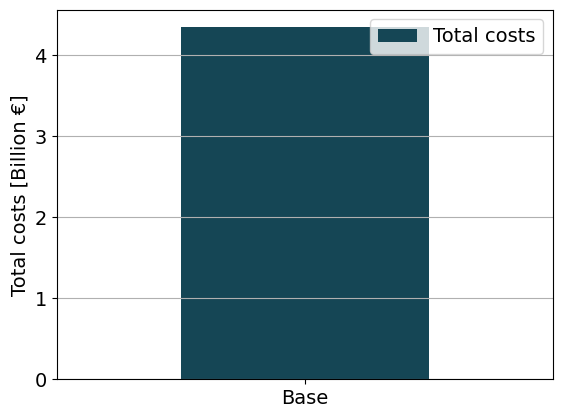

In [ ]:
total_costs = objective_value.iloc[0,1] /1e9
total_costs_df = pd.DataFrame(total_costs, index=['Base'],  columns=['Total costs'])
print(total_costs)
total_costs_df.plot(kind='bar', color=teal2)
plt.ylabel('Total costs [Billion €]', fontsize=14)
plt.xticks(rotation = 0, fontsize=14)
plt.grid(axis='y')
plt.show()

In [ ]:
if cost_method == 'old':
    periods = ['2025-2030', '2030-2035', '2035-2040']
    i = 1
    capex_dict = []
    capex_by_type = []
    for period in periods:
        # Filter data once per period
        investment_filtered = investment_data[investment_data['Period'] == period]
        transmission_filtered = transmission_data[transmission_data['Period'] == period]
        storage_filtered = stor_data[stor_data['Period'] == period]
        
        # Capex by type: Generators
        capex_by_type.append({
            'Period': period, 
            'Type': 'Generators', 
            'Investment': investment_filtered['DiscountedInvestmentCost_Euro'].sum() / 1e6
        })
        
        # Capex by type: Transmission Lines
        capital_cost_lines = 0
        for index in transmission_filtered.index:
            annuity = calculate_annuity_transmision(transmission_filtered.loc[index, 'BetweenNode'], transmission_filtered.loc[index, 'AndNode'])
            capital_cost_lines += annuity * transmission_filtered.loc[index, 'transmisionInvCap_MW'] * empire_factor(i, 40)

        pv_lines = calculate_present_value(capital_cost_lines, 2025 + (i-1)*5, 2025)
        
        capex_by_type.append({
            'Period': period, 
            'Type': 'Transmission Lines', 
            'Investment': pv_lines / 1e6
        })
        
        # Capex by type: Storage
        capex_by_type.append({
            'Period': period, 
            'Type': 'Storage', 
            'Investment': storage_filtered['DiscountedInvestmentCostPWEN_EuroPerMWMWh'].sum() / 1e6
        })

        sum_capex = (investment_filtered['DiscountedInvestmentCost_Euro'].sum() +
                pv_lines +
                storage_filtered['DiscountedInvestmentCostPWEN_EuroPerMWMWh'].sum())
        capex_dict.append({'Period': period, 'TotalInvestment': sum_capex / 1e6})
        
        i += 1

    pv_capital_costs = pd.DataFrame(capex_dict)
    capex_by_type_df = pd.DataFrame(capex_by_type)

    print(pv_capital_costs.sum())

Period             2025-20302030-20352035-2040
TotalInvestment                       2,367.36
dtype: object


In [ ]:
if cost_method == 'new':
    periods = ['2025-2030', '2030-2035', '2035-2040']
    period_map = {
    '2025-2030': 1,
    '2030-2035': 2,
    '2035-2040': 3,
    }
    pv_capital_costs = []
    capex_by_type = []

    for period in periods:
        gen_capex = 0
        total_investment = 0
        total_gen_investment = 0
        total_bat_investment = 0
        total_transmission_investment = 0

        for tech in old_names:
            accumulated_gen_investement = investment_data[(investment_data['Period'].map(period_map) <= period_map[period]) & (investment_data['GeneratorType'] == tech.replace(" ",""))]['genInvCap_MW'].sum()
            gen_capex += accumulated_gen_investement * calculate_annuity_gen(tech)

        accumulated_power_investments = stor_data[(stor_data['Period'].map(period_map) <= period_map[period])]['storPWInvCap_MW'].sum()
        power_capex = accumulated_power_investments * calculate_annuity_stor('Li-Ion_BESS')[0]
        accumulated_energy_investments = stor_data[(stor_data['Period'].map(period_map) <= period_map[period])]['storENInvCap_MWh'].sum()
        energy_capex = accumulated_energy_investments * calculate_annuity_stor('Li-Ion_BESS')[1]
        accumulated_transmission_investments = transmission_data[(transmission_data['Period'].map(period_map) <= period_map[period])]['transmisionInvCap_MW'].sum()
        transmission_capex = accumulated_transmission_investments * calculate_annuity_transmision()
        sum_capex = gen_capex + power_capex + energy_capex + transmission_capex
        for i in range(5):
            total_investment += calculate_present_value(sum_capex, 2025 + i + (5*(period_map[period]-1)), 2025)
            total_gen_investment += calculate_present_value(gen_capex, 2025 + i + (5*(period_map[period]-1)), 2025)
            total_bat_investment += calculate_present_value(power_capex+energy_capex, 2025 + i + (5*(period_map[period]-1)), 2025)
            total_transmission_investment += calculate_present_value(transmission_capex, 2025 + i + (5*(period_map[period]-1)), 2025)
        
        pv_capital_costs.append({'Period': 2025 + (i*period_map[period]), 'TotalInvestment': total_investment/1e6})
        capex_by_type.append({'Period': 2025 + (i*period_map[period]), 'Type': 'Generators', 'Investment':  total_gen_investment/1e6})
        capex_by_type.append({'Period': 2025 + (i*period_map[period]), 'Type': 'Transmission Lines', 'Investment':  total_transmission_investment/1e6})
        capex_by_type.append({'Period': 2025 + (i*period_map[period]), 'Type': 'Storage', 'Investment': total_bat_investment/1e6})


    pv_capital_costs = pd.DataFrame(pv_capital_costs)
    capex_by_type_df = pd.DataFrame(capex_by_type)
    print('Capex: ',pv_capital_costs['TotalInvestment'].sum() / 1e3)

In [ ]:
if new_run:
    load_shed_cost = node_sheet['NodeLostLoadCost']['C4'].value
    operational_scalar = sum((1+discountrate)**(-j) for j in list(range(0,LeapYearsInvestment)))
    opex_dict = {}
    opex_by_type = []
    for period, num_period in zip(periods, range(1, len(periods) + 1)):
        sum_opex = 0
        discount_multiplier = 1
        if num_period > 1:
            discount_multiplier = pow(1.0 + discountrate, -LeapYearsInvestment * (num_period - 1))
        for i in range(scenario_int):
            for tech in old_names:
                tech_no_space = tech.replace(" ", "")
                generated = operational_data[(operational_data['Period'] == period) & (operational_data['Scenario'] == f'scenario{i+1}') & (operational_data['Season'].isin(regular_seasons))][tech_no_space + '_MW'].sum()
                generated_peak = operational_data[(operational_data['Period'] == period) & (operational_data['Scenario'] == f'scenario{i+1}') & (operational_data['Season'].isin(peak_seasons))][tech_no_space + '_MW'].sum()
                gen_opex = get_marginal_cost(tech,num_period) * (generated * season_scale[0] + generated_peak * season_scale[5]) * prob_scenarios[f'scenario{i+1}'] * discount_multiplier * operational_scalar
                sum_opex += gen_opex
                opex_by_type.append({'Period': num_period, 'Type': tech, 'Investment':  gen_opex/1e6})
            load_shed_opex = operational_data[(operational_data['Period'] == period) & (operational_data['Scenario'] == f'scenario{i+1}') & (operational_data['Season'].isin(regular_seasons))]['LoadShed_MW'].sum() * load_shed_cost * season_scale[0] * prob_scenarios[f'scenario{i+1}'] * discount_multiplier * operational_scalar
            opex_by_type.append({'Period': num_period, 'Type': 'Load Shedding', 'Investment':  load_shed_opex/1e6})
            sum_opex += load_shed_opex
       
        opex_dict[period] = sum_opex / 1e6 # in billion euro
    opex = pd.DataFrame(list(opex_dict.items()), columns=['Period', 'TotalOperationalCost'])
    opex_by_type_df = pd.DataFrame(opex_by_type)

Capex:  2.3673630749292496
Opex:  1.9764533827068573
NPV:  4.343816457636107


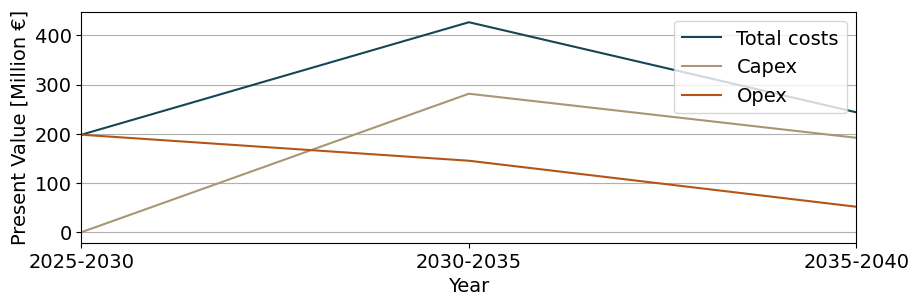

In [ ]:
npv = pv_capital_costs['TotalInvestment'].sum() + opex['TotalOperationalCost'].sum()
print('Capex: ',pv_capital_costs['TotalInvestment'].sum() / 1e3)
print('Opex: ', opex['TotalOperationalCost'].sum() / 1e3) 
print('NPV: ', npv /1e3)

years = [2025, 2030, 2035]
total_costs = [pv_capital_costs.loc[i,'TotalInvestment'] + opex.loc[i,'TotalOperationalCost'] for i in range(len(periods))]
total_costs_df = pd.DataFrame(total_costs, index=periods, columns=['Total costs'])
plt.figure(figsize=(10, 3))
plt.plot(periods, total_costs_df['Total costs']/5, color=teal2, label ='Total costs')
plt.plot(periods, pv_capital_costs['TotalInvestment']/5, color=beige2, label = 'Capex')
plt.plot(periods, opex['TotalOperationalCost']/5, color=brown2, label = 'Opex')
plt.xlabel('Year')
#plt.xticks(years, [int(year) for year in years])
plt.ylabel('Present Value [Million €]', fontsize=14)
plt.xlim(0,2)
#plt.ylim(0,400)
plt.grid(axis='y')
plt.legend()
plt.show()


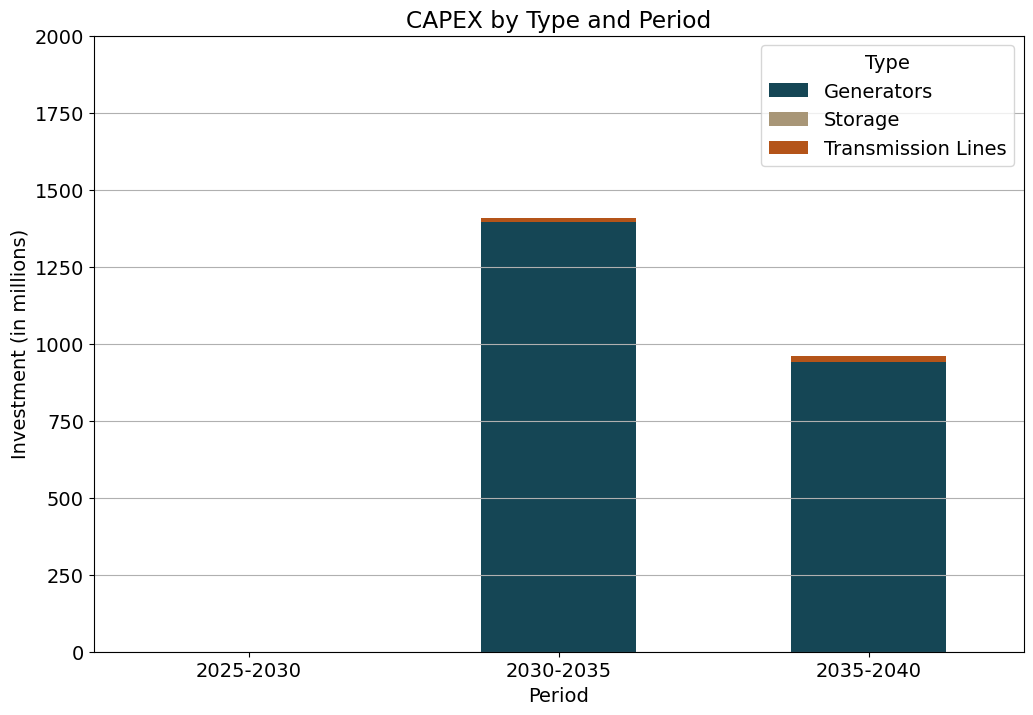

Type       Generators  Storage  Transmission Lines
Period                                            
2025-2030        0.00     0.00                0.00
2030-2035    1,394.30     0.00               13.42
2035-2040      940.68     0.00               18.96


In [ ]:
fig, ax = plt.subplots()
capex_by_type_df.pivot(index='Period', columns='Type', values='Investment').plot(kind='bar', stacked=True, figsize=(12, 8), ax=ax, color=[teal2, beige2, brown2])
ax.set_ylabel('Investment (in millions)')
ax.set_title('CAPEX by Type and Period')
plt.xticks(rotation = 0)
plt.ylim(0,2000)
plt.grid(axis='y')
plt.show()
print(capex_by_type_df.pivot(index='Period', columns='Type', values='Investment'))

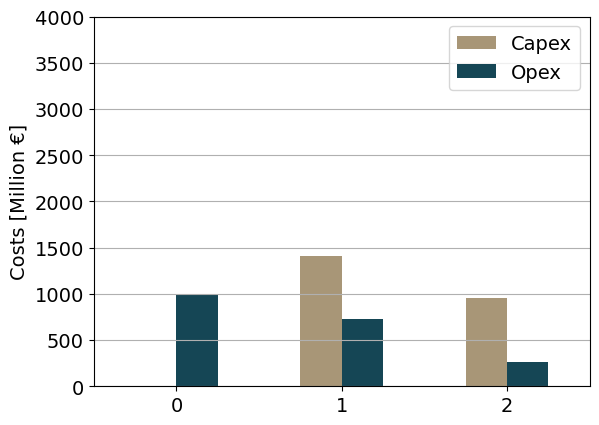

In [ ]:
cost_dataframe = pd.DataFrame({'Capex': pv_capital_costs['TotalInvestment'], 'Opex': opex['TotalOperationalCost']})
cost_dataframe.plot(kind='bar', color=[beige2, teal2])
plt.ylabel('Costs [Million €]', fontsize=14)
plt.xticks(rotation = 0, fontsize=14)
plt.grid(axis='y')
plt.ylim(0,4000)
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


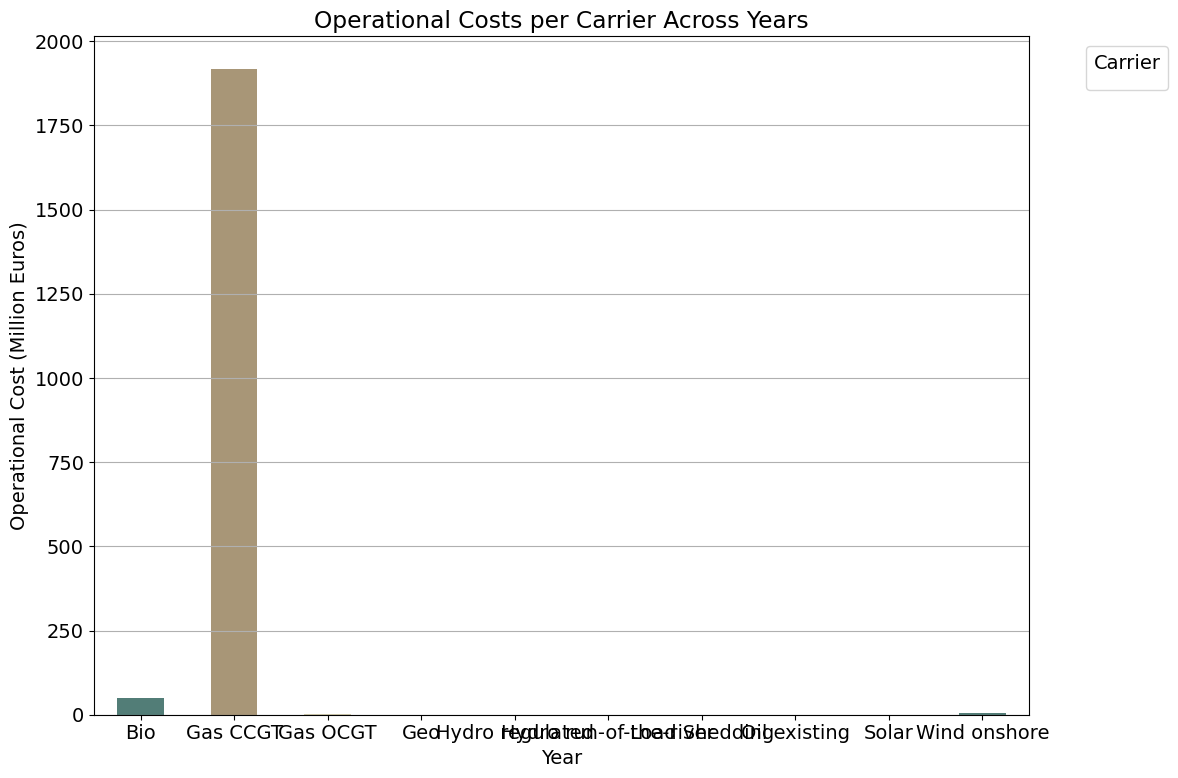

Type
Bio                         49.99
Gas CCGT                 1,918.77
Gas OCGT                     3.26
Geo                          0.00
Hydro regulated              0.00
Hydro run-of-the-river       0.00
Load Shedding                0.00
Oil existing                 0.00
Solar                        0.16
Wind onshore                 4.27
dtype: float64

In [ ]:
fig, ax = plt.subplots()
opex_by_type_df.pivot(columns='Type', values='Investment').sum().plot(kind='bar', stacked=True, figsize=(12,8), ax=ax, color=[teal3,beige2,beige3,brown2,teal2,teal2,beige1,yellow,teal4])
plt.xlabel('Year')
plt.ylabel('Operational Cost (Million Euros)')
plt.title('Operational Costs per Carrier Across Years')
plt.legend(title='Carrier', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y')
plt.xticks(rotation=0)
#plt.ylim(0,350)
plt.tight_layout()
plt.show()
opex_by_type_df.pivot(columns='Type', values='Investment').sum()

Opex:  1.9764533827068573
Capex:  2.3673630749292496


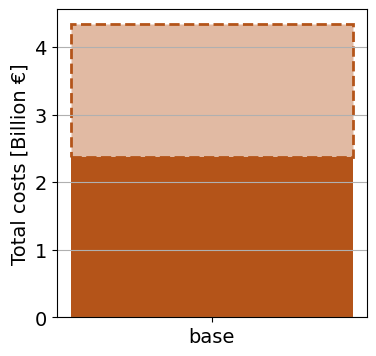

In [ ]:
capex_tot = pv_capital_costs['TotalInvestment'].sum() /1e3
opex_tot = opex['TotalOperationalCost'].sum() / 1e3
print('Opex: ', opex_tot)
print('Capex: ', capex_tot)

fig, ax = plt.subplots(figsize=(4, 4))
capex_bars = ax.bar('base', capex_tot, color=brown2)
fill_colors_with_alpha = [mcolors.to_rgba(brown2, alpha=0.4)]
solid_edge_colors = [mcolors.to_rgba(brown2, alpha=1)] 
opex_bars = ax.bar('base', opex_tot, bottom=capex_tot, color=fill_colors_with_alpha, edgecolor=solid_edge_colors, linestyle='--', linewidth=2)

plt.ylabel('Total costs [Billion €]', fontsize=14)
plt.xticks(rotation = 0, fontsize=14)
plt.grid(axis='y')
plt.show()